### CS281A Final Project MAB - Gale–Shapley Matching version
- exploration vs exploitation dilemma
- https://www.ijcai.org/Proceedings/05/Papers/0334.pdf
- https://github.com/lilianweng/multi-armed-bandit

In [290]:
from __future__ import division

import time
import numpy as np
import matplotlib
import random
from matplotlib import pyplot as plt

from scipy.stats import beta
from scipy.stats import truncnorm
from numpy import argsort

import warnings
warnings.filterwarnings("ignore")

### Some help functions

In [291]:
# genearte positive Gaussian rewards
def get_truncated_normal(mean=0, sd=1, low=0, upp=10):
    return truncnorm((low-mean)/sd, (upp-mean)/sd, loc=mean, scale=sd)

# turn reward_matrix into preference dictionary
def preference_dic(reward_matrix_, init_index=0, end_index=0):
    # here init_index and end_index will help differentiate agents/arms
    temp_dic = {}
    for i in range(len(reward_matrix_)):    
        # descending order preference
        temp_order = list(np.flip(argsort(reward_matrix_[i,])))
        temp_dic[i+init_index] = np.add(temp_order, end_index).tolist()
    return temp_dic
    
# example
X = get_truncated_normal(mean=5, sd=2, low=0, upp=10)
print(X.rvs())
A = np.random.rand(5,5)
# print(preference_dic(A, 0))
preference_dic(A, 5, 0)

7.323622291158386


{5: [0, 4, 2, 3, 1],
 6: [4, 3, 2, 1, 0],
 7: [3, 0, 2, 4, 1],
 8: [0, 1, 2, 4, 3],
 9: [0, 2, 3, 4, 1]}

### Gale–Shapley algorithm implementation
- Plug in mean-rewarded  preference matrices will return one-to-one matching pairs
- https://github.com/alextanhongpin/stable-marriage-problem/blob/master/python/main.ipynb

In [292]:
class Agent:
    def __init__(self, name, preference):
        """
        Preference here actually is the ranking of estimated mean vector at previous step
        """
        self.name = name
        self.preference = preference
        self.is_matched = False
        self.partner = None
        self.index = 0 # Index to hold the position of the proposed wives
    
    def propose(self):
        arm = self.preference[self.index]
        self.index += 1
        return arm
    
    def is_available(self):
        return not self.is_matched

In [293]:
class Arm:
    def __init__(self, name, preference):
        """
        Preference here actually is the ranking of estimated mean vector at previous step
        """
        self.name = name
        self.preference = preference
        self.is_matched = False
        self.partner = None
    
    def is_available(self):
        return not self.is_matched

    def rank(self, m1, m2):
        m1_score = self.preference.index(m1)
        m2_score = self.preference.index(m2)

        # Lower index means higher preference
        return m1 if m1_score < m2_score else m2

In [294]:
class Matches:
    def __init__(self, agents, arms):
        self.matches = {}

        self.choices = len(agents)
        self.agents = list(agents.keys())
        self.arms = list(arms.keys())
        self.match_count = 0
        
        for i in agents:
            self.matches[i] = Agent(i, agents[i])

        for j in arms:
            self.matches[j] = Arm(j, arms[j])
        
    def engage(self, agent_name, arm_name):
        agent = self.matches[agent_name]
        arm = self.matches[arm_name]
        
        agent.is_matched = True
        agent.partner = arm
        
        arm.is_matched = True
        arm.partner = agent
        
        self.match_count += 1
    def breakup(self, agent_name, arm_name):
        agent = self.matches[agent_name]
        arm = self.matches[arm_name]
        
        agent.is_matched = False
        agent.partner = None
        
        arm.is_matched = False
        arm.partner = None

        self.match_count -= 1
    
    def match(self):
        for m in self.agents:
            agent = self.matches[m]
            if not agent.is_available():
                continue

            arm = self.matches[agent.propose()]
            if arm.is_available():
                self.engage(agent.name, arm.name)
            else:
                agent_name = arm.rank(agent.name, arm.partner.name)
                self.breakup(arm.partner.name, agent_name)
                self.engage(agent_name, arm.name)
        if self.match_count < self.choices:
            self.match()

        return self.sets()
    
    def sets(self):
        matches = {}
        for i in self.matches:
            match = self.matches[i]
            matches[frozenset([match.name, match.partner.name])] = True
        return list(matches.keys())

In [295]:
def load_data(n = None):
    agents = {'k': ['b', 'c', 'a'],
              'l': ['a', 'c', 'b'],
              'm': ['a', 'b', 'c']}

    arms = {'a': ['k', 'l', 'm'],
            'b': ['l', 'm', 'k'],
            'c': ['m', 'l', 'k']}            
    return agents, arms

In [296]:
# Test Example
agent_data, arm_data = load_data(0)
matches = Matches(agent_data, arm_data)
matches.match()

[frozenset({'c', 'k'}), frozenset({'a', 'l'}), frozenset({'b', 'm'})]

In [297]:
# Aggregate function
# given two reward_matrices and return stable matching pairs
def stable_matching_pair(reward_matrix_agent_, reward_matrix_arm_):
    agent_data = preference_dic(reward_matrix_agent_, 0, len(reward_matrix_agent_))
    arm_data = preference_dic(reward_matrix_arm_, len(reward_matrix_agent_))
    matches = Matches(agent_data, arm_data)
    frozensetmatch = matches.match()
    return [sorted(list(key_)) for key_ in frozensetmatch]

# Test
A1 = np.random.rand(6, 6)
A2 = np.random.rand(6, 6)
result = stable_matching_pair(A1, A2)
print(result)

[[0, 7], [1, 8], [2, 10], [3, 6], [4, 9], [5, 11]]


#### Define Bandit and GaussianBandit object

In [298]:
class Bandit(object):
    def generate_reward(self, matching_dic_):
        raise NotImplementedError
        
class GaussianBandit(Bandit):
    """
    with Gaussian rewards
    """
    def __init__(self, n, mean_matrix=None):
        assert mean_matrix is None or ((len(mean_matrix) == n) & (len(mean_matrix[:,0]) == n))
        self.n = n
        # if we don't have any learned mean_matrix, we generate some random mean samples
        # Here agents/arms' mean_rewards don't have to be the same
        """
        if mean_matrix is None:
            np.random.seed(random.randint(1, 1000000))
            self.mean_matrix = np.random.rand(self.n, self.n)
        else:
            self.mean_matrix = mean_matrix
        """
        if mean_matrix is None:
            options = [i*0.5 for i in range(self.n)]
            self.mean_matrix = np.zeros((self.n,self.n))
            for i in range(self.n):
                np.random.seed(random.randint(1, 1000000))
                self.mean_matrix[i,:] = random.sample(options, len(options))
        else:
            self.mean_matrix = mean_matrix
        
    def generate_reward(self, matching_dic_):
        # The agent-arm matches following matching_dic_
        # Here we assign all Gaussian Bandit has variance == 1
        # now reward should be a matrix as well rather than scalar
        reward_matrix = np.zeros((self.n, self.n))
        for pair_ in matching_dic_:
            # pair - (agent, arm)
            short_pair1 = pair_[1] - len(matching_dic_)
            np.random.seed(random.randint(1, 1000000))
            X = get_truncated_normal(mean=self.mean_matrix[pair_[0]][short_pair1], sd=1e-2, low=0, upp=10)
            reward_matrix[pair_[0]][short_pair1] = X.rvs()
        return reward_matrix

### Define Generalized Solver object
- Solver will keep track of actions, regret and help run steps etc.

In [299]:
class Solver(object):
    def __init__(self, bandit_arm, bandit_agent):
        """
        bandit (Bandit): the target bandit to solve.
        """
        assert isinstance(bandit_arm, GaussianBandit)
        assert isinstance(bandit_agent, GaussianBandit)
        np.random.seed(int(time.time()))
        self.bandit_arm = bandit_arm
        self.bandit_agent = bandit_agent
        self.counts_agent = np.zeros((self.bandit_agent.n,self.bandit_arm.n))
        self.counts_arm = np.zeros((self.bandit_arm.n,self.bandit_agent.n))
        self.actions = [] # A list of list of stable matching pairs each step
        self.regret_agent = [0.] *  self.bandit_arm.n # Cumulative regret - each regret is a vector
        self.regret_arm = [0.] * self.bandit_agent.n
        self.regrets_agent = [] # History of cumulative regret - a list of regret
        self.regrets_arm = []
        
    def update_regret(self, matching_pair_list_):
        # matching_pair_list_: index of matching pair between agents and arms
        # Our loss function is the total regret we might have by not selecting the optimal bandit up to the time step T
        
        # compute regret for agent by using bandit_arm
        # generate rewards based on above matched_mean
        np.random.seed(random.randint(1, 1000000))
        match_mean_rewards = self.bandit_arm.generate_reward(matching_pair_list_)
        # based on true mean_matrix + Gale Shapley algorithm - find stable matching
        
        "Optimal"
        # true_matching_pair_list_ = stable_matching_pair(self.bandit_arm.mean_matrix, self.bandit_agent.mean_matrix)
        # true_match_mean_rewards = self.bandit_arm.generate_reward(true_matching_pair_list_)
        
        "Pessimal"
        true_matching_pair_list_ = stable_matching_pair(self.bandit_agent.mean_matrix, self.bandit_arm.mean_matrix)
        true_matching_pair_list_ = [[pair_[1]-self.bandit_agent.n, pair_[0]+self.bandit_agent.n] for pair_ in true_matching_pair_list_]
        true_match_mean_rewards = self.bandit_arm.generate_reward(true_matching_pair_list_)    
        regret1 = np.amax(true_match_mean_rewards, 1) - np.amax(match_mean_rewards, 1)
        
        # compute regret for arm by using bandit_agent
        # matched_mean = [self.bandit_agent.mean_matrix[pair_[1]-len(matching_pair_list_)][pair_[0]] for pair_ in matching_pair_list_]
        np.random.seed(random.randint(1, 1000000))
        match_mean_rewards = self.bandit_agent.generate_reward(matching_pair_list_).transpose()
        true_match_mean_rewards = self.bandit_agent.generate_reward(true_matching_pair_list_).transpose()
        regret2 = np.amax(true_match_mean_rewards, 1) - np.amax(match_mean_rewards, 1)
        
        # aggregate
        self.regret_agent = np.add(self.regret_agent, regret1)
        self.regret_arm = np.add(self.regret_arm, regret2)
        self.regrets_agent.append(self.regret_agent)
        self.regrets_arm.append(self.regret_arm)
        
    @property
    def estimated_mean_vector(self):
        raise NotImplementedError
    
    def run_one_step(self):
        """Return the machine index to take action on."""
        raise NotImplementedError
    
    def run(self, num_steps):
        assert self.bandit_agent is not None
        assert self.bandit_arm is not None
        for _ in range(num_steps):
            matching_dic = self.run_one_step()
            # update two counts matrices
            for pair_ in matching_dic:
                short_pair1 = pair_[1] - len(matching_dic)
                self.counts_agent[pair_[0]][short_pair1] += 1
                self.counts_arm[short_pair1][pair_[0]] += 1
            # update actions
            self.actions.append(matching_dic)
            # update regret
            self.update_regret(matching_dic)

### Define two-sided UCB Solver object

In [300]:
class Two_sided_UCB(Solver):
    def __init__(self, bandit_arm, bandit_agent, init_mean_arm=1.0, init_mean_agent=1.0):
        super(Two_sided_UCB, self).__init__(bandit_arm, bandit_agent)
        self.t = 0
        self.estimatesOfAgent = init_mean_arm * np.ones((self.bandit_agent.n,self.bandit_arm.n))
        self.estimatesOfArm = init_mean_agent * np.ones((self.bandit_arm.n,self.bandit_agent.n))
        
    @property
    def estimated_mean_vector(self):
        return self.estimatesOfAgent, self.estimatesOfArm
    
    def run_one_step(self):
        self.t += 1
        # update mean_reward estimate by further calculating UCB 
        # choose the matching pair from Gale-Shapley algorithm stable matching result
        # UCB_estimateOfAgent_UCB = self.estimatesOfAgent + np.sqrt(2*np.log(self.t)/(1+self.counts_agent))
        UCB_estimateOfAgent_UCB = self.estimatesOfAgent + np.sqrt(3*np.log(self.t)/((1+self.counts_agent)))
        # UCB_estimateOfArm_UCB = self.estimatesOfArm + np.sqrt(2*np.log(self.t)/(1+self.counts_arm))
        UCB_estimateOfArm_UCB = self.estimatesOfArm + np.sqrt(3*np.log(self.t)/((1+self.counts_arm)))
        
        # if the arm has never been pulled then set UCB to be infinite large
        for len_ in range(len(self.counts_agent)):
            for width_ in range(len(self.counts_agent[len_, :])):
                if self.counts_agent[len_][width_] == 0:
                    UCB_estimateOfAgent_UCB[len_][width_] = np.inf
        for len_ in range(len(self.counts_arm)):
            for width_ in range(len(self.counts_arm[len_, :])):
                if self.counts_arm[len_][width_] == 0:
                    UCB_estimateOfArm_UCB[len_][width_] = np.inf
        matching_dic = stable_matching_pair(UCB_estimateOfAgent_UCB, UCB_estimateOfArm_UCB) # list of pair-list
        
        np.random.seed(random.randint(1, 1000000))
        r_arm = self.bandit_arm.generate_reward(matching_dic)
        r_agent = self.bandit_agent.generate_reward(matching_dic).transpose()
        
        self.estimatesOfAgent += 1. / (self.counts_agent + 1) * (r_agent - self.estimatesOfAgent)
        # print(self.estimatesOfAgent)
        self.estimatesOfArm += 1. / (self.counts_arm + 1) * (r_arm - self.estimatesOfArm)
        # print(matching_dic)
        return matching_dic                                           

In [301]:
def experiment(K, N):
    """
    Run a small experiment on solving a Gaussian bandit with K slot machines and K agents,
    each with a randomly initialized reward probability.
    Args:
        K (int): number of slot machines/agents.
        N (int): number of time steps to try.
    """
    g_arm = GaussianBandit(K)
    g_agent = GaussianBandit(K)
    test_solver = Two_sided_UCB(g_arm, g_agent)
    test_solver.run(N)
    estimateOfAgent, estimateOfArm = test_solver.estimated_mean_vector
       
    # print("Bandit_arm mean matrix: \n", test_solver.bandit_arm.mean_matrix)
    # print(estimateOfAgent)
    # print("Bandit_agent mean matrix: \n", test_solver.bandit_agent.mean_matrix)
    # print(estimateOfArm)
    
    # print(" ")
    regrets_agent = test_solver.regrets_agent
    regrets_arm = test_solver.regrets_arm
    return regrets_agent, regrets_arm

In [302]:
num_agent = 3
regrets_agent, regrets_arm = experiment(num_agent, 1000)

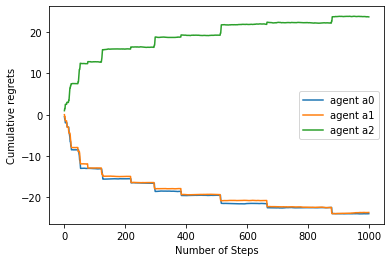

In [271]:
for j in range(num_agent):
    regret_temp = [ regrets_agent[i][j] for i in range(len(regrets_agent))]
    plt.plot(range(len(regret_temp)), regret_temp, label="agent a"+str(j))
plt.legend()
plt.xlabel("Number of Steps")
plt.ylabel("Cumulative regrets")
plt.savefig('fig1.png')

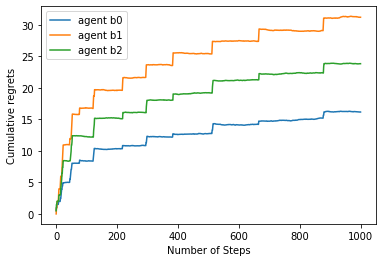

In [272]:
for j in range(num_agent):
    regret_temp = [ regrets_arm[i][j] for i in range(len(regrets_agent))]
    plt.plot(range(len(regret_temp)), regret_temp, label="agent b"+str(j))
plt.legend()
plt.xlabel("Number of Steps")
plt.ylabel("Cumulative regrets")
plt.savefig('fig2.png')

In [ ]:
regrets_agent_init, regrets_arm_init = experiment(num_agent, 500)
for _ in range(20):
    temp1, temp2 = experiment(num_agent, 500)
    regrets_agent_init += temp1
    regrets_arm_init += temp2
    print(_)

In [305]:
print(regrets_agent_init[-1]/20)
print(regrets_arm_init[-1]/20)

[20.65435074 -8.77499701  0.11379421]
[ -1.06363212 -11.89500244 -19.59289267]
